In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, datasets, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


Epoch 29/100: training accuracy: 0.486586493987049, valid accuracy: 0.2809917355371901,train loss: 1.8025611994114328,valid loss:2.3270930672480055


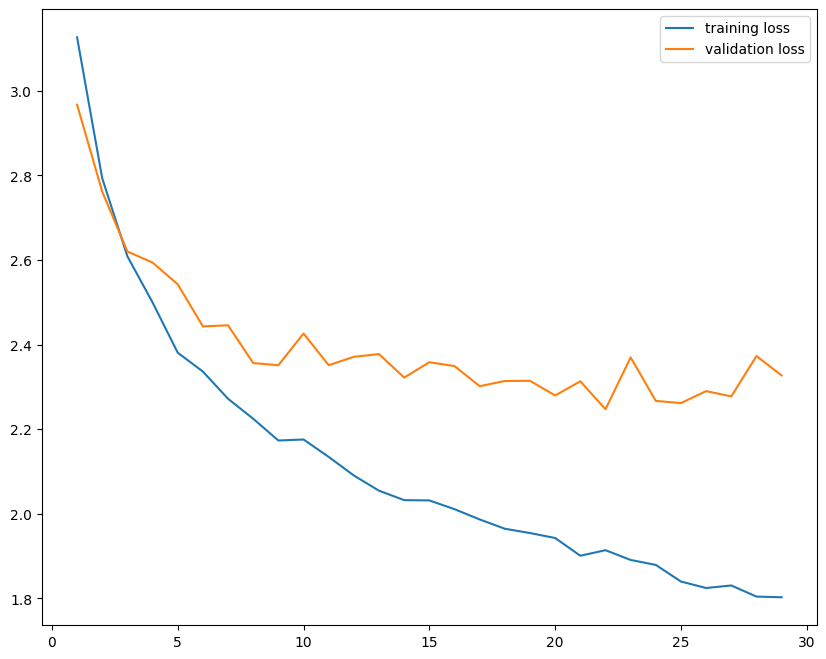

In [2]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = False

    
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)    

mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()    

In [ ]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = False

    
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)    

mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()    

In [2]:
def M_B_model(num):
    bird_model = models.mobilenet_v2()
    num_ftrs = bird_model.classifier[1].in_features
    bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
    bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

    for param in bird_model.parameters():
        param.requires_grad = False

    for i in range(0,num):
        for param in bird_model.features[i].parameters():
            param.requires_grad = True

    num_ftrs = bird_model.classifier[1].in_features
    bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

    for param in bird_model.classifier.parameters():
        param.requires_grad = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bird_model = bird_model.to(device)    

    mean = [0.4914, 0.4822, 0.4465] 
    std = [0.2470, 0.2435, 0.2616] 
    batch_size = 64
    n_epochs = 100

    train_transform = transforms.Compose([ 
    transforms.Resize((224,224)), 
    transforms.RandomCrop(224, padding=4), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
    ])

    path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
    all_train = datasets.ImageFolder(root = path, transform = train_transform)
    train_size = int(0.9 * len(all_train ))
    validation_size = len(all_train) - train_size
    train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=3
    )
    val_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=3
    )

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

    class EarlyStopper:
        def __init__(self, patience=1, min_delta=0):
            self.patience = patience
            self.min_delta = min_delta
            self.counter = 0
            self.min_validation_loss = np.inf

        def early_stop(self, validation_loss):
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
            elif validation_loss > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False

    def train(model, train_loader, optimizer, loss_fn):
        model.train()
        train_loss = 0.
        corrects=0
        total = 0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad() # step 1
            images = images.to(device)
            labels = labels.to(device)
            

            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            total += labels.size(0)
            
            loss.backward() # step 4 (backpropagation)
            optimizer.step()

            train_loss += loss.item()*images.size(0)
        
            
        train_loss = train_loss/len(train_loader.sampler)
        
        return train_loss, corrects/total    


    @torch.no_grad()
    def validate(model, valid_loader, loss_fn):
        model.eval()
        losses=0.
        corrects=0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images = images.to(device)
                labels = labels.to(device)
                
                    
                logits = model(images) # step 2 (forward pass)
                loss = loss_fn(logits, labels) # step 3 (compute loss)
                total += labels.size(0)
                
                _, predictions = torch.max(logits, dim=1)
                corrects += predictions.eq(labels).sum().item()
                
                losses += loss.item()*images.size(0)    
                
            valid_loss = losses/len(valid_loader.sampler)
        return valid_loss, corrects / total


    # is_valid_available = True
    # scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

    train_loss_list = []
    valid_loss_list = []

    early_stopper = EarlyStopper(patience=7)

    for epoch in range(n_epochs):
        training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
        
        train_loss_list.append(training_loss)
        valid_loss_list.append(valid_loss)

        # if scheduler is not None and is_valid_available:
        #     scheduler.step(valid_loss)
        # elif scheduler is not None:
        #     scheduler.step()

        if early_stopper.early_stop(valid_loss):
            print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
            break

    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
    ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
    ax.legend()

In [3]:
def M_B_model_freeze(num):
    bird_model = models.mobilenet_v2()
    num_ftrs = bird_model.classifier[1].in_features
    bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
    bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

    for param in bird_model.parameters():
        param.requires_grad = True

    for i in range(0,num):
        for param in bird_model.features[i].parameters():
            param.requires_grad = False

    num_ftrs = bird_model.classifier[1].in_features
    bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

    for param in bird_model.classifier.parameters():
        param.requires_grad = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bird_model = bird_model.to(device)    

    mean = [0.4914, 0.4822, 0.4465] 
    std = [0.2470, 0.2435, 0.2616] 
    batch_size = 64
    n_epochs = 100

    train_transform = transforms.Compose([ 
    transforms.Resize((224,224)), 
    transforms.RandomCrop(224, padding=4), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
    ])

    path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
    all_train = datasets.ImageFolder(root = path, transform = train_transform)
    train_size = int(0.9 * len(all_train ))
    validation_size = len(all_train) - train_size
    train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=3
    )
    val_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=3
    )

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

    class EarlyStopper:
        def __init__(self, patience=1, min_delta=0):
            self.patience = patience
            self.min_delta = min_delta
            self.counter = 0
            self.min_validation_loss = np.inf

        def early_stop(self, validation_loss):
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
            elif validation_loss > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False

    def train(model, train_loader, optimizer, loss_fn):
        model.train()
        train_loss = 0.
        corrects=0
        total = 0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad() # step 1
            images = images.to(device)
            labels = labels.to(device)
            

            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            total += labels.size(0)
            
            loss.backward() # step 4 (backpropagation)
            optimizer.step()

            train_loss += loss.item()*images.size(0)
        
            
        train_loss = train_loss/len(train_loader.sampler)
        
        return train_loss, corrects/total    


    @torch.no_grad()
    def validate(model, valid_loader, loss_fn):
        model.eval()
        losses=0.
        corrects=0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images = images.to(device)
                labels = labels.to(device)
                
                    
                logits = model(images) # step 2 (forward pass)
                loss = loss_fn(logits, labels) # step 3 (compute loss)
                total += labels.size(0)
                
                _, predictions = torch.max(logits, dim=1)
                corrects += predictions.eq(labels).sum().item()
                
                losses += loss.item()*images.size(0)    
                
            valid_loss = losses/len(valid_loader.sampler)
        return valid_loss, corrects / total


    # is_valid_available = True
    # scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

    train_loss_list = []
    valid_loss_list = []

    early_stopper = EarlyStopper(patience=7)

    for epoch in range(n_epochs):
        training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
        
        train_loss_list.append(training_loss)
        valid_loss_list.append(valid_loss)

        # if scheduler is not None and is_valid_available:
        #     scheduler.step(valid_loss)
        # elif scheduler is not None:
        #     scheduler.step()

        if early_stopper.early_stop(valid_loss):
            print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
            break

    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
    ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
    ax.legend()

100%|██████████| 2/2 [00:06<00:00,  3.47s/it]

Epoch 16/100: training accuracy: 0.5883441258094357, valid accuracy: 0.35537190082644626,train loss: 1.440425010547938,valid loss:2.342780635376607


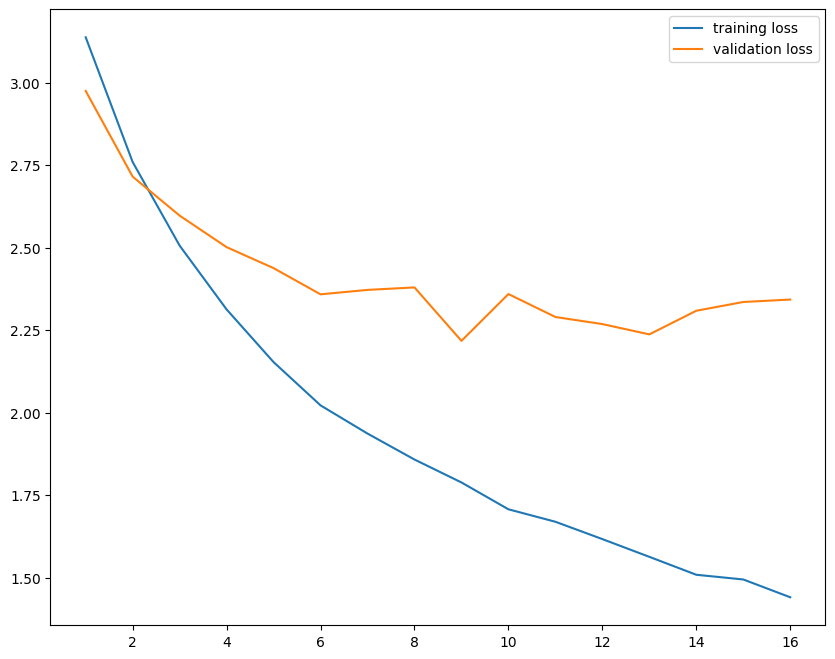

In [6]:
M_B_model(4)

100%|██████████| 2/2 [00:07<00:00,  3.64s/it]


Epoch 13/100: training accuracy: 0.9944495837187789, valid accuracy: 0.5867768595041323,train loss: 0.05028522874088225,valid loss:1.55312458739793


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 25/100: training accuracy: 0.8353376503237743, valid accuracy: 0.47107438016528924,train loss: 0.6251359909469612,valid loss:1.879408665925018


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Epoch 15/100: training accuracy: 0.996299722479186, valid accuracy: 0.6198347107438017,train loss: 0.03250151797508774,valid loss:1.5038536718069029


100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


Epoch 27/100: training accuracy: 0.9796484736355227, valid accuracy: 0.6198347107438017,train loss: 0.17470444092366785,valid loss:1.5726677809865022


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 12/100: training accuracy: 0.9935245143385754, valid accuracy: 0.4628099173553719,train loss: 0.07750070815652636,valid loss:1.9922032750342502


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 31/100: training accuracy: 1.0, valid accuracy: 0.5454545454545454,train loss: 0.030250876469952878,valid loss:1.5442808974872937


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 14/100: training accuracy: 0.9953746530989824, valid accuracy: 0.5371900826446281,train loss: 0.06019297184269259,valid loss:1.9530480114881656


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Epoch 26/100: training accuracy: 1.0, valid accuracy: 0.628099173553719,train loss: 0.013352370177370657,valid loss:1.3682914932897268


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 13/100: training accuracy: 0.9620721554116559, valid accuracy: 0.4132231404958678,train loss: 0.241447648221315,valid loss:2.151906967163086


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Epoch 21/100: training accuracy: 0.9990749306197965, valid accuracy: 0.628099173553719,train loss: 0.01591447124147407,valid loss:1.495009524763123


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 32/100: training accuracy: 0.482886216466235, valid accuracy: 0.4049586776859504,train loss: 1.7591820739133837,valid loss:2.4173005651836554


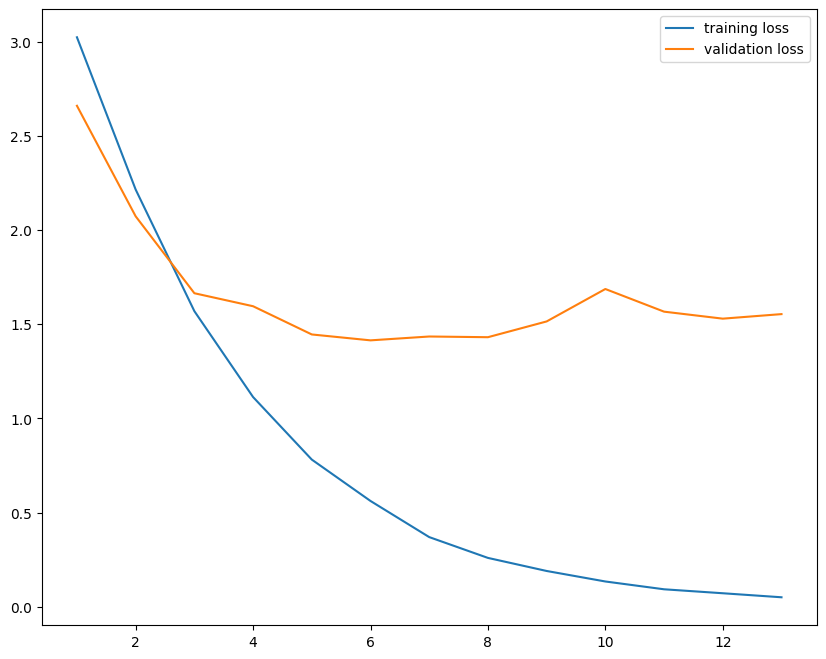

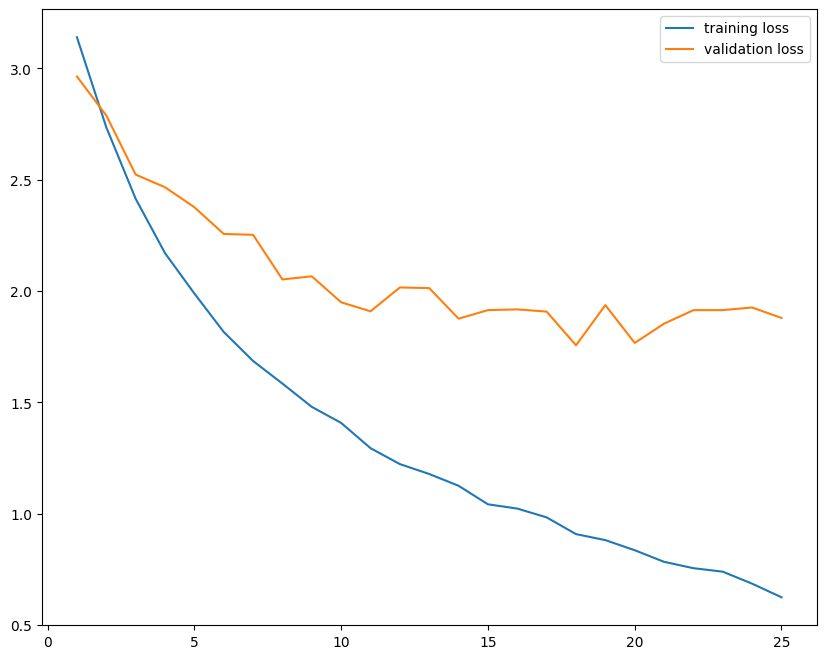

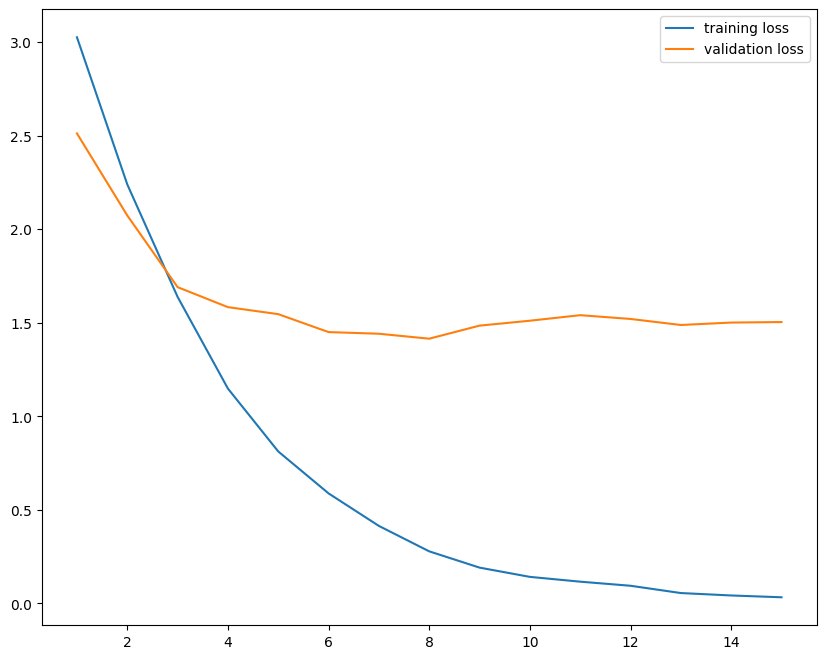

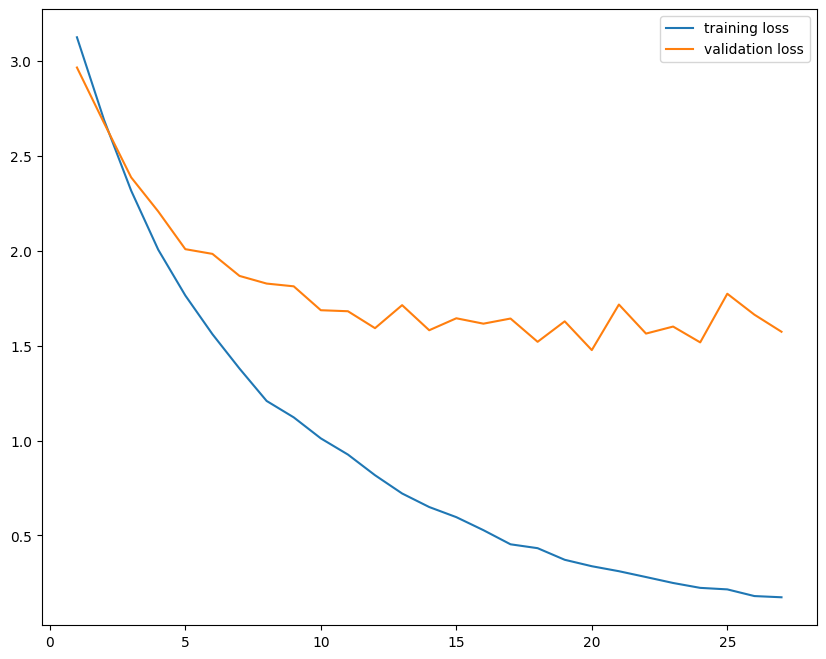

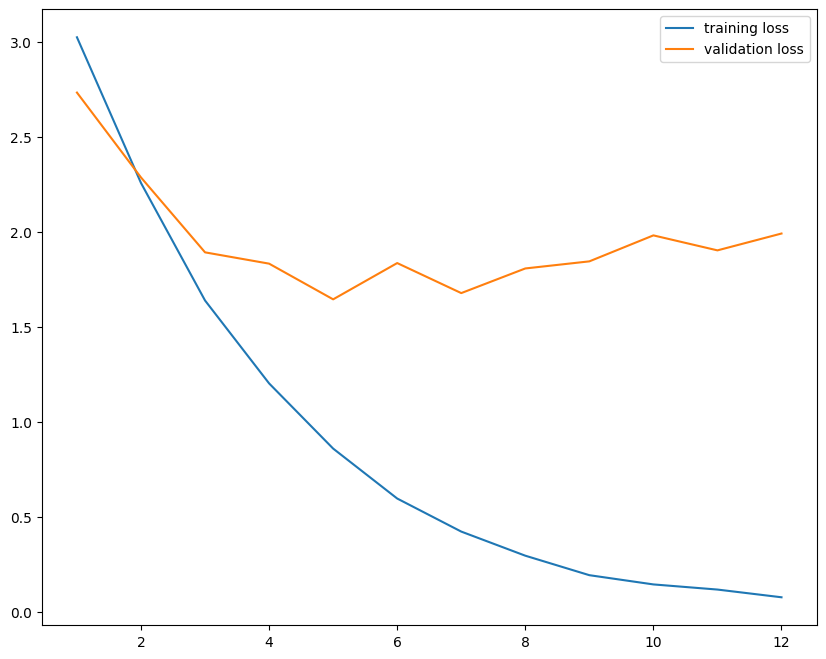

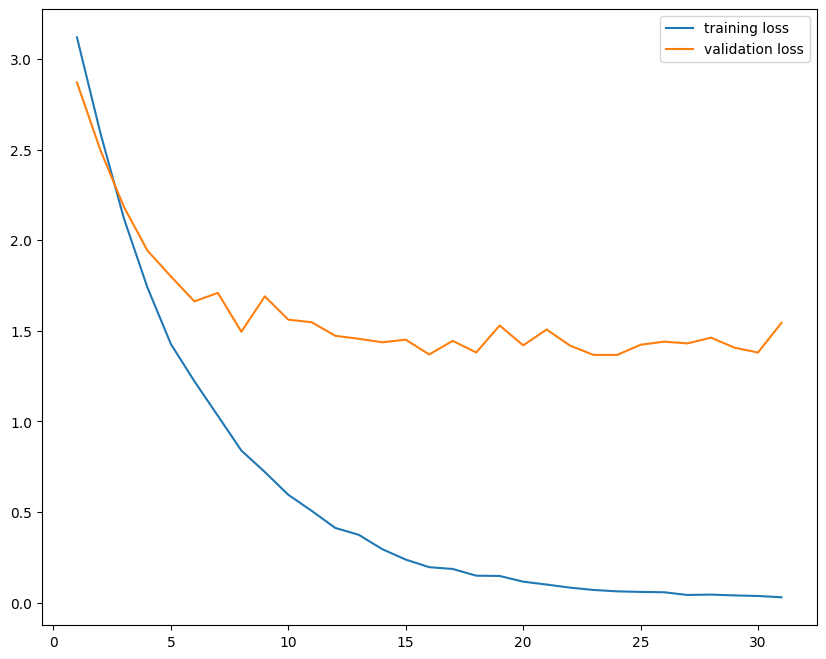

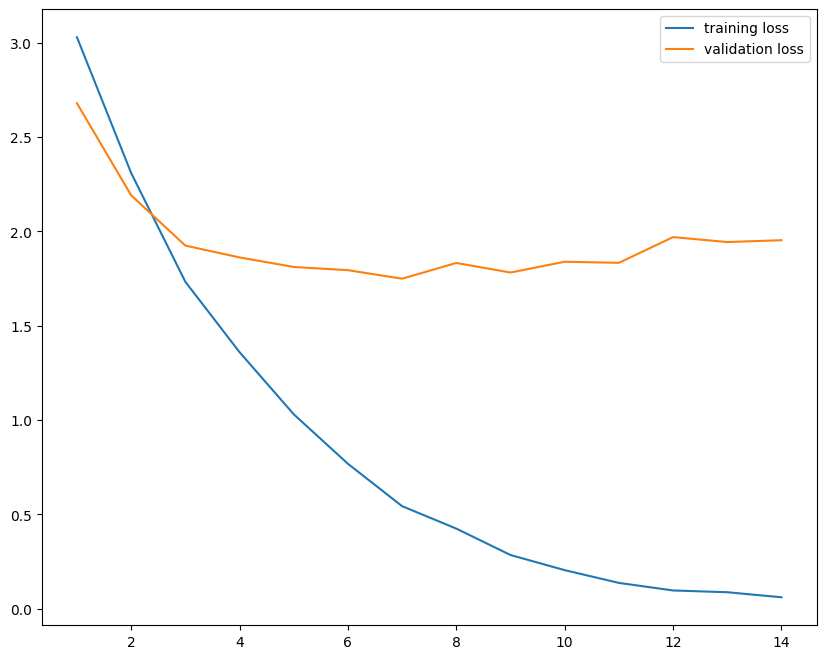

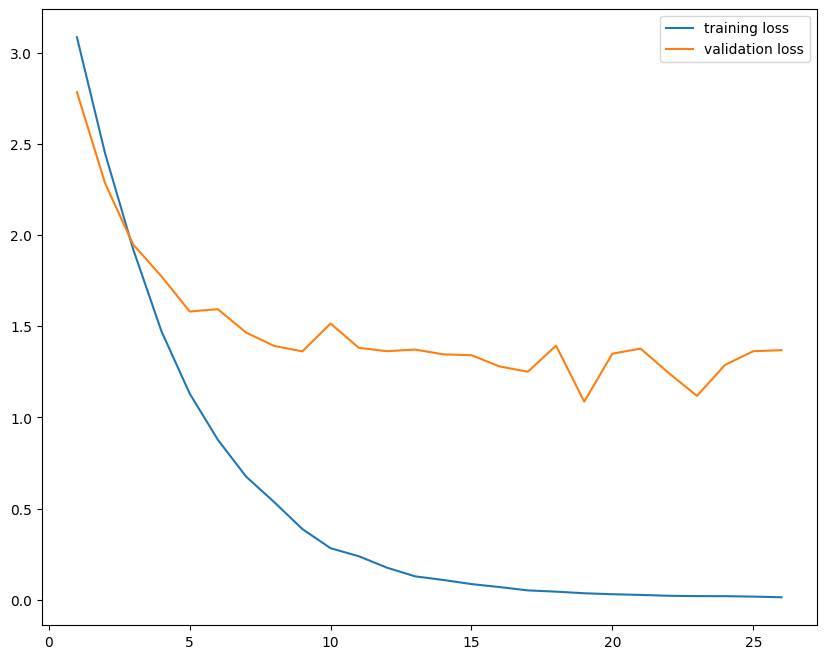

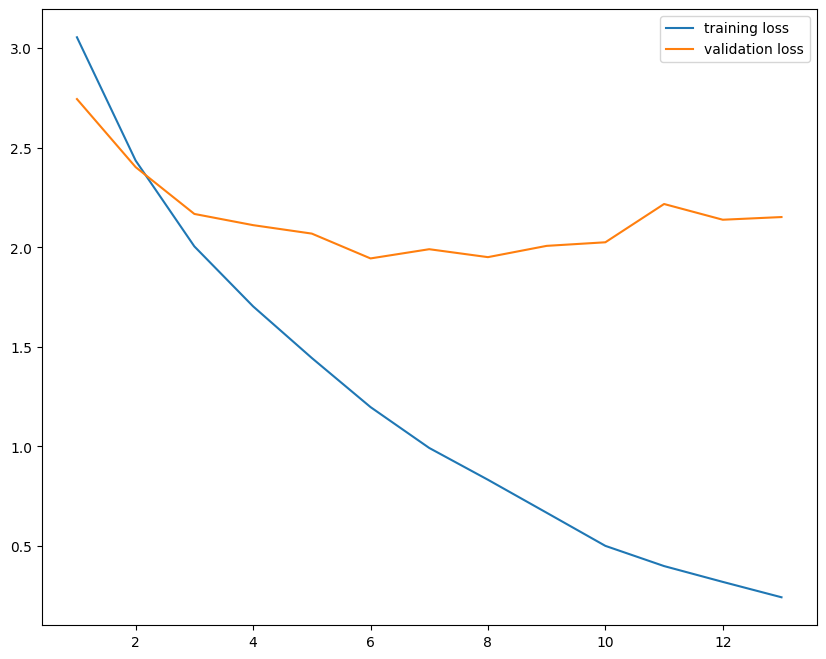

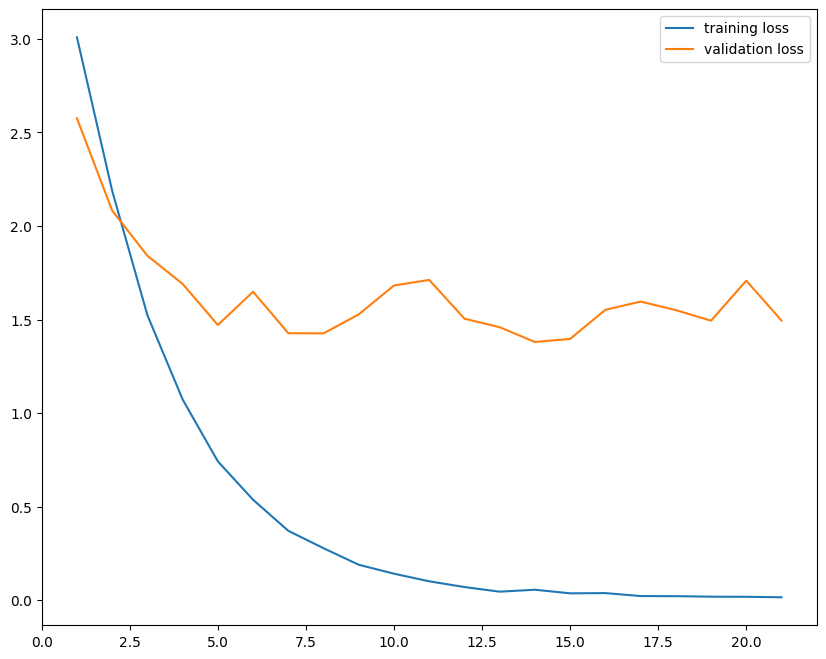

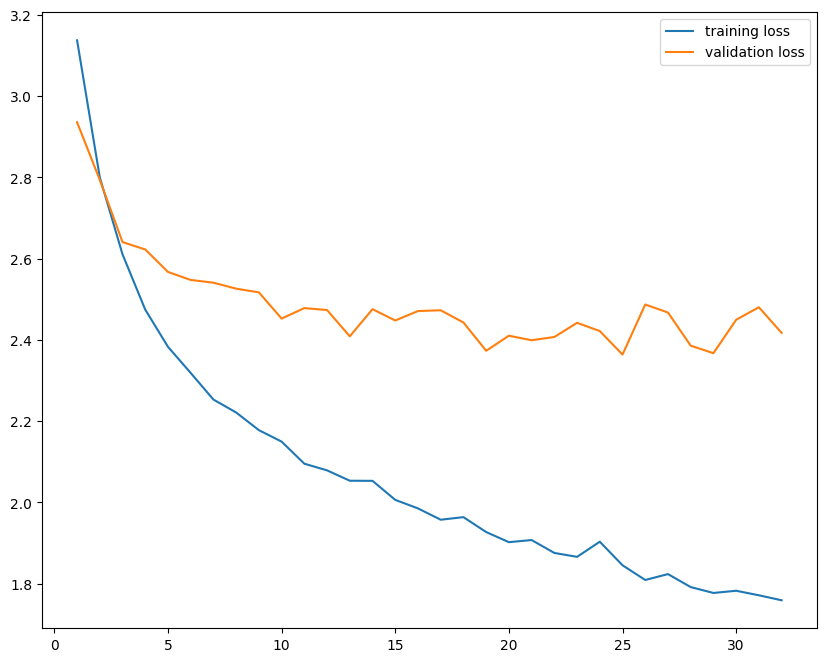

In [4]:
M_B_model_freeze(4)
M_B_model(7)
M_B_model_freeze(7)
M_B_model(10)
M_B_model_freeze(10)
M_B_model(13)
M_B_model_freeze(13)
M_B_model(16)
M_B_model_freeze(16)
M_B_model(19)
M_B_model_freeze(19)

In [ ]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = False

for i in range(0,6):
    for param in bird_model.features[i].parameters():
        param.requires_grad = True

num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)    

mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()

100%|██████████| 2/2 [00:07<00:00,  3.64s/it]

Epoch 31/100: training accuracy: 0.7974098057354302, valid accuracy: 0.5041322314049587,train loss: 0.6924272414493297,valid loss:1.5230560194362293


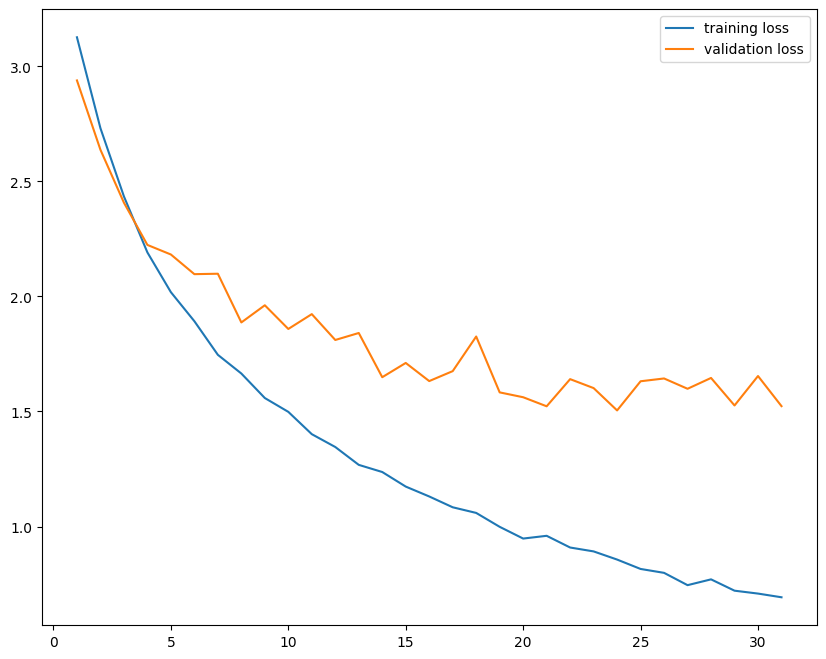

In [10]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = False

for i in range(0,6):
    for param in bird_model.features[i].parameters():
        param.requires_grad = True

num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)    

mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()

100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Epoch 27/100: training accuracy: 0.9722479185938946, valid accuracy: 0.5619834710743802,train loss: 0.19542383855410356,valid loss:1.5487465759939398


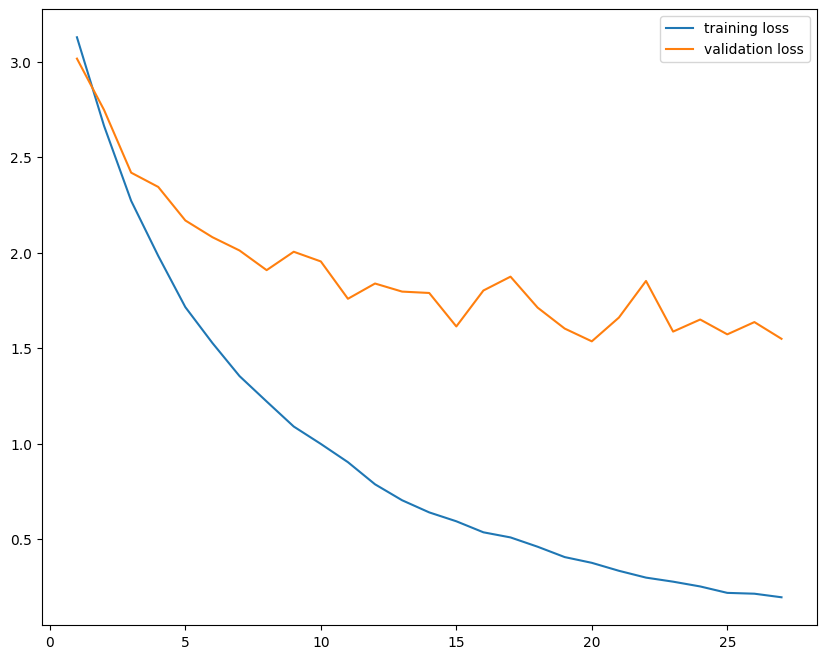

In [3]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = False

for i in range(0,10):
    for param in bird_model.features[i].parameters():
        param.requires_grad = True

    
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()